In [2]:
import pandas as pd
import numpy as np
import datetime
import random
import warnings
warnings.simplefilter('ignore')
from random import shuffle
from tqdm import tqdm
from scipy import sparse as sp
from collections import Counter
import re
import copy
import matplotlib.pyplot as plt
from math import log
#import implicit
import pickle
from sklearn.metrics.pairwise import euclidean_distances
import string
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
import ast
import requests
from PIL import Image
from io import StringIO, BytesIO

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

## Read Data

In [303]:
bids = pd.read_csv('bids.csv')
sales = pd.read_csv('sales.csv')
tokens = pd.read_csv('tokens.csv')

In [4]:
bids.shape, sales.shape, tokens.shape

((51640, 8), (17529, 9), (22232, 14))

# Bids

In [5]:
bids

,timestamp,tokenId,bidder,eth,rate,usd,contract,transactionId
0,2018-04-16T18:11:00Z,1,0x388f16be771be7392ae0e11422951620ec4555c3,0.001,511.67,0.51167,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xb03cb308ed7b397e9c95fd66dfa2574cf1e12f0a5cb1...
1,2018-04-16T18:58:27Z,1,0x3950cf9d61851259b0694a0a3800f51658cb920a,0.470,511.67,240.48490,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x034a179079157243bfd2d60486cbc0ad94e2fd2a4418...
2,2018-04-17T00:33:27Z,1,0x337101def3eeb6f06e071efe02216274507937bb,0.475,503.03,238.93925,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xde7bf8fbc62fa211ff4dfc966460437b8018f841bacc...
3,2018-05-06T19:30:24Z,1,0x3950cf9d61851259b0694a0a3800f51658cb920a,0.470,790.39,371.48330,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x96cbaa6de5c4593c9db6cd219ebec297a1e0098d4e5e...
4,2018-05-19T21:59:45Z,1,0x55372173689c288552885d897d32f5f706f79aa6,0.500,696.05,348.02500,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xf483fe1b7a693c40d19a916f91692face2003d125e55...
...,...,...,...,...,...,...,...,...
51635,2021-03-26T13:16:58Z,22227,0x657d3bbd8651945f755f272b5c996eece411836c,0.300,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0xf698adf8a1f59148733af08fbb5a502043c1780d4692...
51636,2021-03-26T13:44:25Z,22227,0x86e578946d012b73c4b62070af5c8c9e62d5a22a,0.500,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x5119f2880217a3d08f062370511b257f0c0d2b32c01c...
51637,2021-03-26T14:34:34Z,22227,0x2debdf4427ccbcfdbc7f29d63964499a0ec184f6,1.250,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x9eb201163511f0fdacf384bf4f97bfe02bec56326853...
51638,2021-03-26T13:50:48Z,22230,0x3eb18413d536d7ab03320300598de457fa078ab2,2.100,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x77f447376811b6886fb26c3ee119eb21358a9c5df064...


In [6]:
len(bids['tokenId'].unique()), len(bids['bidder'].unique()), len(bids['contract'].unique()), len(bids['transactionId'].unique())

(15954, 4445, 2, 51640)

In [7]:
np.nanmin(bids['usd']), np.nanmedian(bids['usd']), np.nanmean(bids['usd']), np.nanmax(bids['usd'])

(1.3974000000000003e-16, 198.245, 1571.9718355380783, 525032.64)

In [8]:
bids['timestamp'] = pd.to_datetime(bids['timestamp'])
bids.sort_values('timestamp', inplace=True)

### Bidder stats

In [9]:
stats = bids[['bidder', 'tokenId']].groupby('bidder').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count'])

(11.617547806524184, 2.0)

In [10]:
stats2 = bids[['bidder', 'usd']].groupby('bidder').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(1689.2714568176184, 334.813295882353)

In [11]:
stats = pd.merge(stats, stats2, on='bidder', how='left')
stats

,bidder,count,mean
0,0x99d46eb671bfb7f367ebf9d5fc76b99587277de5,3234,34.393658
1,0xe703f231ab056ecb99c92a1232cc1020acfc72f8,1443,333.557582
2,0x5da7351a4cb03c33e11f51841bc614d985812821,1054,592.717132
3,0xd2af803ad747ea12acf5ae468056703ae48785b5,1044,564.716550
4,0xf52393e120f918ffba50410b90a29b1f8250c879,913,599.491495
...,...,...,...
4440,0x7b39be4ff5d78a941fc6f6a5752476ad7560bcdb,1,208.413800
4441,0x7b3aa2c76a147dd060e998c7ea8e5c81434a9cfb,1,206.270000
4442,0x7b413076d7bfe35a1e81e7dd490c7ab3e88dae73,1,38.361000
4443,0x7b8405d2e5c06156c6336666a0d9029a6c3b1364,1,73.071000


In [12]:
np.mean(stats[stats['count']>5]['mean']), np.nanmedian(stats[stats['count']>5]['mean'])

(2117.395490242345, 607.0988750000001)

In [13]:
np.mean(stats[stats['count']==1]['mean']), np.nanmedian(stats[stats['count']==1]['mean'])

(1319.1596321314012, 197.84525)

### TokenId stats

In [14]:
stats = bids[['bidder', 'tokenId']].groupby('tokenId').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count'])

(3.236805816723079, 2.0)

In [15]:
stats2 = bids[['tokenId', 'usd']].groupby('tokenId').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(1099.125637549466, 171.27939791666665)

In [16]:
stats3 = bids[['tokenId', 'usd']].groupby('tokenId').max().reset_index()
stats3.rename(columns={'usd': 'max'}, inplace=True)
stats3 = stats3.sort_values('max', ascending=False)
np.mean(stats3['max']), np.nanmedian(stats3['max'])

(2083.655686709771, 248.91325)

In [17]:
stats = pd.merge(stats, stats2, on='tokenId', how='left')
stats = pd.merge(stats, stats3, on='tokenId', how='left')
stats, np.mean(stats['max']/stats['mean']), np.nanmedian(stats['max']/stats['mean'])

(       tokenId  count          mean         max
 0         5051     44   3425.482994  69825.9600
 1           47     39   2442.541340  27146.4000
 2        13670     39   6498.316769  34254.1500
 3          343     39    931.653762   2154.9000
 4        16297     35  16440.650431  88085.4700
 ...        ...    ...           ...         ...
 15949    10223      1    107.365000    107.3650
 15950    10219      1     68.127500     68.1275
 15951    10214      1     60.996000     60.9960
 15952    10212      1     32.270700     32.2707
 15953    22237      1           NaN         NaN
 
 [15954 rows x 4 columns], 1.6375860934149453, 1.3389071354149489)

# Sales

In [18]:
sales

,timestamp,tokenId,buyer,seller,eth,rate,usd,contract,transactionId
0,2018-04-05T23:50:12Z,1,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0.46,381.36,175.4256,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xf1097e3617632e43b7c0a46ffeb4d741d0a67b25fb06...
1,2020-01-18T16:16:42Z,1,0x54d7f921785ebe46010d83c73712e80dfaff1e81,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,75.00,174.00,13050.0000,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xf8d3b8be83601d0351c72d2093738a4a25c70b49503b...
2,2021-01-05T00:47:24Z,1,0xd0c0650cd08acd4e9553c48c60c94be04fecce43,0x54d7f921785ebe46010d83c73712e80dfaff1e81,100.00,1103.19,110319.0000,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xc917fe7d09a750c09fd8f467d60e5adac4bbd3a5e5ea...
3,2018-04-05T23:59:06Z,2,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0.46,381.36,175.4256,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x9e9befc01fe11425ae8a2b903c8f8e1ec9777157d3e9...
4,2018-09-05T21:06:04Z,2,0x6853a596d6d7264d3622546da3b891b6fe17eb82,0xbc74c3adc2aa6a85bda3eca5b0e235ca08532772,1.85,228.27,422.2995,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x6425dbd16550508c7c0ca320a1e6d7cb2ba2d3b2aea5...
...,...,...,...,...,...,...,...,...,...
17524,2021-03-25T23:48:06Z,22179,0x6641f026da7cc01ce6ff5a55355f64f6345aa499,0x7177b44fcf24ea77b7285ba85055bce7db8b5b13,1.20,1588.34,1906.0080,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x07a6e96473a958e6ed8e49821b80e8bddf713a033868...
17525,2021-03-26T07:26:39Z,22182,0xa54b343d5e65cadea794445452d1779bac2e7f40,0xb7ae801d15a727dc975282aee2060eb88d2787f7,0.50,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x49be0967a667d04ac764ef8c94a709ba47d3850fa7a9...
17526,2021-03-26T05:55:00Z,22206,0x0a2542a170aa02b96b588aa3af8b09ab22a9d7ac,0x68f0114d8bd222e816843aa2f52aede00d8e2c22,8.88,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x4ebff4a57e9a57735a28eae05c00f08e8efd9735ec84...
17527,2021-03-26T09:03:24Z,22215,0x576a655161b5502dcf40602be1f3519a89b71658,0x16aac3c06f7e4da97c29d0f14126517e37b9f43f,0.50,NaN,NaN,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0xb823b737b3e964f096f96f9903fcd4b7145c993ecd74...


In [19]:
sales['timestamp'] = pd.to_datetime(sales['timestamp'])
sales.sort_values('timestamp', inplace=True)

In [20]:
len(sales['tokenId'].unique()), len(sales['buyer'].unique()), len(sales['seller'].unique()), len(sales['contract'].unique()), len(sales['transactionId'].unique())

(14482, 2369, 1409, 2, 17529)

In [21]:
stats = sales[['tokenId', 'transactionId']].groupby('tokenId').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
stats, stats[stats['count']>1].shape[0]/stats.shape[0], np.mean(stats['count']), np.mean(stats[stats['count']>1]['count']),

(       tokenId  count
 565       1000      9
 163        365      6
 141        172      5
 3994      5796      5
 4530      6510      4
 ...        ...    ...
 5592      7938      1
 5593      7940      1
 5595      7942      1
 5596      7943      1
 14481    22230      1
 
 [14482 rows x 2 columns],
 0.18312387791741472,
 1.210399116144179,
 2.14894419306184)

### Buyer stats

In [22]:
stats = sales[['buyer', 'tokenId']].groupby('buyer').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count']), stats[stats['count']>1].shape[0]/stats.shape[0]

(7.399324609539891, 2.0, 0.5293372731110173)

In [23]:
stats2 = sales[['buyer', 'usd']].groupby('buyer').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(2290.0944322074365, 483.336)

In [24]:
stats = pd.merge(stats, stats2, on='buyer', how='left')
stats

,buyer,count,mean
0,0xe703f231ab056ecb99c92a1232cc1020acfc72f8,594,415.607802
1,0xd2af803ad747ea12acf5ae468056703ae48785b5,501,454.490776
2,0xf52393e120f918ffba50410b90a29b1f8250c879,443,623.171617
3,0x5da7351a4cb03c33e11f51841bc614d985812821,373,577.919711
4,0xdc19d539369c3da9172de453c05bc503c9ac6bc2,343,80.421080
...,...,...,...
2364,0x72809c6bfa9cd0e5710aad436185fd7a04b70fb3,1,14560.776322
2365,0x723b49349b8bca5255ad06d1aa96488ad30906f3,1,2374.860000
2366,0x720fff4f23db9644daa375ed68bae5029e9751cb,1,45.298000
2367,0x71cc25e270560ab31d5d2e15e5bf896ebfc4a640,1,1261.370000


In [25]:
np.mean(stats[stats['count']>1]['count']), np.median(stats[stats['count']>1]['count']),np.mean(stats[stats['count']>5]['mean']), np.median(stats[stats['count']>5]['mean'])

(13.089314194577353, 4.0, 2807.34165704768, 614.4953837121365)

### Seller stats

In [26]:
stats = sales[['seller', 'tokenId']].groupby('seller').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count']), stats[stats['count']>1].shape[0]/stats.shape[0]

(12.440738112136266, 3.0, 0.680624556422995)

In [27]:
stats2 = sales[['seller', 'usd']].groupby('seller').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(5826.617372084014, 1378.48814375)

In [28]:
stats = pd.merge(stats, stats2, on='seller', how='left')
stats

,seller,count,mean
0,0x10017ca37b1257ac0771e24652aa28c758e378eb,286,2582.868779
1,0x8b7adc43153bcfae98ab20ce9fff23331f542387,233,655.646844
2,0x99d46eb671bfb7f367ebf9d5fc76b99587277de5,210,266.913910
3,0x2e0b873d26f6d90f347757ed0d041bc65e02a89f,209,77.720539
4,0x576a655161b5502dcf40602be1f3519a89b71658,203,303.844940
...,...,...,...
1404,0x39d050c98dba7df8236d6860cddac8b6a6ff4a2b,1,5437.336000
1405,0x39df69adc718924b63dd5ebe9ccebe1f5d7072c6,1,5805.420000
1406,0x98c1d8a5cd2e6fa559ba6ae0680b388b799ac231,1,4195.586000
1407,0xa16ce88f9f702d390244ce016f9416b23c9c3027,1,3656.632500


In [29]:
np.mean(stats[stats['count']>1]['count']), np.median(stats[stats['count']>1]['count']),np.mean(stats[stats['count']>5]['mean']), np.median(stats[stats['count']>5]['mean'])

(17.80917622523462, 7.0, 2553.9708190483, 926.2515052631579)

# Tokens

In [30]:
tokens

,tokenId,name,description,tags,image,media,type,size,dimensions,creator,owner,timestamp,contract,transactionId
0,1,AI Generated Nude Portrait #1,"Robbie Barrat, AI Generated, 2018",Nude Portrait AI Painting Portrait Generat...,https://ipfs.pixura.io/ipfs/QmX4ECCmA4HZSPxzsg...,NaN,NaN,NaN,NaN,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0xd0c0650cd08acd4e9553c48c60c94be04fecce43,2018-04-05T23:20:48Z,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xf3e68d3a53b1bb3a2cdb4aa3a6c871626e6dcf7b8df1...
1,2,AI Generated Nude Portrait #2,"Robbie Barrat, AI Generated, 2018",Nude Portrait AI Painting Portrait Generat...,https://ipfs.pixura.io/ipfs/QmRe3WvttmMR7mELga...,NaN,NaN,NaN,NaN,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0x6853a596d6d7264d3622546da3b891b6fe17eb82,2018-04-05T23:49:27Z,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x8fb08cb45e1a0032dccd0951812dba7a8ebe5b255bdd...
2,3,AI Generated Nude Portrait #3,"Robbie Barrat, AI Generated, 2018",Nude Portrait AI Painting Portrait Generat...,https://ipfs.pixura.io/ipfs/QmYCyvs9JwKTAChpri...,NaN,NaN,NaN,NaN,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0x8a0a834077a8ecea4983e2288f81afb2c6764116,2018-04-06T00:07:31Z,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xdf2952f467fddc9f81f6beada8dc2bed1ae4e497c0d2...
3,4,AI Generated Nude Portrait #4,"Robbie Barrat, AI Generated, 2018",Nude Portrait AI Painting Portrait Generat...,https://ipfs.pixura.io/ipfs/Qmar9LZwD1DAVbYe7h...,NaN,NaN,NaN,NaN,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,0xc6d21ad879faadba2fd07db6a599fa0cb6b8505d,2018-04-06T00:09:04Z,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0x29b61df06bc7cd50df888cedb8947162733083fb6a23...
4,5,Echoes of a Dead Earth,"XCOPY, 2018",XCOPY GIF Earth Echoes 2018,https://ipfs.pixura.io/ipfs/QmQnek3m4UtBQxqsqJ...,NaN,NaN,NaN,NaN,0x39cc9c86e67baf2129b80fe3414c397492ea8026,0xe25c73435702fed11e9c5584ce6efe7cbff71739,2018-04-07T20:44:24Z,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,0xd21c6838f94842d3824e800c84a578e7a61cddcfca9a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22227,22238,ADAPTATION,с,CYBERPUNK NEON ACID ROBOT MECHANISM FUTURE FAN...,https://ipfs.pixura.io/ipfs/QmZUDEguZRA4hSUKGw...,https://ipfs.pixura.io/ipfs/QmZUDEguZRA4hSUKGw...,image/jpeg,6107498.0,3879x4654,0x0099330d38d8b8459cb12862114bcb35af716324,0x0099330d38d8b8459cb12862114bcb35af716324,2021-03-26T15:12:13Z,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0xecf11f101471fe60539627e2dc08d82a828db79ec0b6...
22228,22239,A Non-Fungible Dream,In but a moment a digital baby is born in an #...,fineart minimal error dream nft nfts cryptoart...,https://ipfs.pixura.io/ipfs/QmdUvwGPFAj7AfFZYS...,https://ipfs.pixura.io/ipfs/Qmcfc6Eo36d2vuLSgP...,video/mp4,1406722.0,2482x2000,0xa12db9f88f096f527fbe87a752c6ec16d501a25f,0xa12db9f88f096f527fbe87a752c6ec16d501a25f,2021-03-26T15:15:05Z,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x5204f153c017eefa3c766f1ff67992b3fd1b3d509899...
22229,22240,(A) Deal With Self,Outside influences can not fix internal strugg...,illustration Drawing 2D Animation Artwork Rare...,https://ipfs.pixura.io/ipfs/Qmcj6VruB48QDPhnzR...,https://ipfs.pixura.io/ipfs/Qmcj6VruB48QDPhnzR...,image/gif,16465393.0,1920x2715,0xf33654f85ba6b567f8841c8c954635b27e14c49d,0xf33654f85ba6b567f8841c8c954635b27e14c49d,2021-03-26T15:16:24Z,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x1fb7cb2b6b741cdfa17f71ec2a7ac8c45429239f178f...
22230,22241,Azurescens,Psilocybe Azurescens. 1/1. Final one of this s...,rik oostenbroek Rick mushrooms trippy dreamy c...,https://ipfs.pixura.io/ipfs/QmUcfQR88ZeifMiJi5...,https://ipfs.pixura.io/ipfs/QmUcfQR88ZeifMiJi5...,image/jpeg,1120141.0,1600x2114,0x0aadeef83545196ccb2ce70fabf8be1afa3c9b87,0x0aadeef83545196ccb2ce70fabf8be1afa3c9b87,2021-03-26T15:29:44Z,0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0,0x5935a0aa0fc5f12ab4e684c5b5f1974c98c2b0322431...


In [31]:
len(tokens['tokenId'].unique()), len(tokens['name'].unique()), len(tokens['description'].unique()), len(tokens['tags'].unique())

(22229, 20981, 19626, 19852)

In [32]:
len(tokens['media'].unique()), len(tokens['type'].unique()), len(tokens['size'].unique()), len(tokens['dimensions'].unique())

(13452, 9, 13427, 4543)

In [33]:
len(tokens['creator'].unique()), len(tokens['owner'].unique()), len(tokens['contract'].unique()), len(tokens['transactionId'].unique())

(904, 3527, 2, 20442)

In [34]:
tokens['type'].unique()

array([nan, 'video/mp4', 'image/png', 'image/jpeg', 'video/webm',
       'image/gif', 'image/svg+xml', 'model/gltf-binary', 'image/apng'],
      dtype=object)

In [5]:
tokens['timestamp'] = pd.to_datetime(tokens['timestamp'])
tokens.sort_values('timestamp', inplace=True)

In [6]:
stats = tokens[['tokenId']].groupby('tokenId').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
stats

,tokenId,count
4433,4435,2
4434,4436,2
3619,3620,2
0,1,1
14820,14829,1
...,...,...
7410,7417,1
7409,7416,1
7408,7415,1
7407,7414,1


In [7]:
tokens.drop(tokens[tokens['tokenId'].isin(stats[stats['count']>=2]['tokenId'])][['tokenId']].drop_duplicates(keep='last').index,inplace=True)

### Creator stats

In [839]:
inds_last_sale = sales[~sales['usd'].isnull()][['tokenId']].drop_duplicates(keep='last').index

In [840]:
tokens = pd.merge(tokens, sales.loc[inds_last_sale][['tokenId','usd']], on='tokenId', how='left')

In [40]:
stats = tokens[['creator', 'tokenId']].groupby('creator').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count']), stats[stats['count']>1].shape[0]/stats.shape[0]

(24.589601769911503, 10.0, 0.9037610619469026)

In [41]:
stats2 = tokens[['creator', 'usd']].groupby('creator').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(4258.441972350295, 1494.2605833333332)

In [42]:
stats = pd.merge(stats, stats2, on='creator', how='left')
stats

,creator,count,mean
0,0x8b7adc43153bcfae98ab20ce9fff23331f542387,341,1125.123395
1,0x860c4604fe1125ea43f81e613e7afb2aa49546aa,319,32779.659550
2,0xe388ec519e7ca708cb6ee07431f5d51335cbdaf2,283,85.221253
3,0xc15aa7af05ee4bdd05b475688f912761cfa1df19,251,330.018623
4,0x80cccd71b03d0e68e0539ca2d2308141d74d06dc,250,278.995033
...,...,...,...
899,0x571b70ccf8f44b6c4d44dc414752c71ded66e0ea,1,NaN
900,0x51e9047a6bbec3c2a4c03c27382381b129e99e0e,1,NaN
901,0xead774ea11cbf097776b471a1dab1bf1c06d3969,1,NaN
902,0x2c6d3f3fc4adb0808c163f5d65d86250a393eed7,1,24528.660000


In [43]:
np.mean(stats[stats['count']>1]['count']), np.median(stats[stats['count']>1]['count']), np.mean(stats[stats['count']>5]['mean']), np.nanmedian(stats[stats['count']>5]['mean'])

(27.1015911872705, 12.0, 3187.8775423324087, 1170.2268571428572)

### Owner stats

In [44]:
stats = tokens[['owner', 'tokenId']].groupby('owner').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count']), stats[stats['count']>1].shape[0]/stats.shape[0]

(6.304310833806013, 1.0, 0.4852524106636415)

In [45]:
stats2 = tokens[['owner', 'usd']].groupby('owner').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(2196.666441816243, 471.6042)

In [46]:
stats = pd.merge(stats, stats2, on='owner', how='left')
stats

,owner,count,mean
0,0x41a322b28d0ff354040e2cbc676f0320d8c8850d,1696,NaN
1,0xe7079eec020ddfc3f1c0abe1d946c55e6ed30eb3,510,469.012232
2,0xe25c73435702fed11e9c5584ce6efe7cbff71739,448,219.061501
3,0xf52393e120f918ffba50410b90a29b1f8250c879,421,653.261756
4,0x5da7351a4cb03c33e11f51841bc614d985812821,307,682.610406
...,...,...,...
3521,0x6e9d89f43fc201a92a431eca1c3458a511e93d31,1,NaN
3522,0x6eab8f9b2724b04aed6e7e68f4c1b6158e47e12d,1,73.216000
3523,0x6ebfcdfa38d14197d6e652bfc94ef385d8ccb6ab,1,968.850000
3524,0x6ecf67485948687fdbf6007ba241e4265ccec359,1,363.496000


In [47]:
np.mean(stats[stats['count']>1]['count']), np.median(stats[stats['count']>1]['count']), np.mean(stats[stats['count']>5]['mean']), np.nanmedian(stats[stats['count']>5]['mean'])

(11.931034482758621, 4.0, 2944.2532703338593, 596.9621387193027)

### Type, Size & Dimensions stats

In [48]:
stats = tokens[['type', 'tokenId']].groupby('type').size().reset_index()
stats.rename(columns={0: 'count'},inplace=True)
stats = stats.sort_values('count',ascending=False)
np.mean(stats['count']), np.median(stats['count'])

(1706.5, 1455.5)

In [49]:
stats2 = tokens[['type', 'usd']].groupby('type').mean().reset_index()
stats2.rename(columns={'usd': 'mean'}, inplace=True)
stats2 = stats2.sort_values('mean', ascending=False)
np.mean(stats2['mean']), np.nanmedian(stats2['mean'])

(2172.6717539547994, 1782.6357432444756)

In [50]:
stats = pd.merge(stats, stats2, on='type', how='left')
stats

,type,count,mean
0,video/mp4,4343,4521.354030
1,image/jpeg,3292,3029.174437
2,image/png,3047,1857.879638
3,image/gif,2650,1581.256480
4,model/gltf-binary,261,2964.080589
5,image/svg+xml,27,1218.329176
6,video/webm,26,1707.391848
7,image/apng,6,501.907833


In [51]:
np.min(tokens['size']), np.mean(tokens['size']), np.nanmedian(tokens['size']), np.max(tokens['size'])

(0.0, 18915940.783987693, 13182042.5, 52419856.0)

In [52]:
pixels = [int(x.split('x')[0])*int(x.split('x')[1]) for x in tokens[~tokens['dimensions'].isnull()]['dimensions']]
np.min(pixels), np.mean(pixels), np.median(pixels), np.max(pixels)

(0, 8787908.641251586, 3686400.0, 1024000000)

In [53]:
np.min(np.sqrt(pixels)), np.mean(np.sqrt(pixels)), np.median(np.sqrt(pixels)), np.max(np.sqrt(pixels))

(0.0, 2384.197929878471, 1920.0, 32000.0)

# Tags

In [55]:
all_text = ''
for tag in tokens[~tokens['tags'].isnull()]['tags']:
    all_text += tag+' '

In [56]:
all_text = all_text.replace('\n','').replace('\t','').replace('#','').replace('-','').replace('_','')
all_text = all_text.lower()

In [57]:
all_text[:1000]

'nude portrait  ai  painting  portrait  generative  gan  machine learning  artificial intelligence  nude  abstract nude portrait  ai  painting  portrait  generative  gan  machine learning  artificial intelligence  nude  abstract nude portrait  ai  painting  portrait  generative  gan  machine learning  artificial intelligence  nude  abstract nude portrait  ai  painting  portrait  generative  gan  machine learning  artificial intelligence  nude  abstract xcopy  gif  earth  echoes  2018  xcopy  gif  internet  data  machine  learning  2017 xcopy  gif  asshole  human  2018 xcopy  gif  vaping  fomo  2018 xcopy  gif  greedy  guts  tears  2018 xcopy  gif  banker  bitcoin  death xcopy  gif  the city  death  debt xcopy  gif  screen  time  mirror xcopy  gif  anxiety  panic  pain xcopy  gif  death  dip  lurking xcopy  gif  compulsory  fiction  numbers  2018 xcopy  gif  skeleton  post human  debt  2018 gif  green  drawing  fuckyou  keep calm  girl  door painting  portrait  contemporary art  figurat

In [58]:
Counter(all_text.split()).most_common()

[('3d', 4824),
 ('abstract', 3955),
 ('animation', 3789),
 ('gif', 3734),
 ('art', 3064),
 ('surreal', 2770),
 ('illustration', 2450),
 ('cryptoart', 2370),
 ('portrait', 2148),
 ('3dart', 1893),
 ('digitalart', 1837),
 ('digital', 1792),
 ('generative', 1769),
 ('loop', 1700),
 ('ai', 1599),
 ('painting', 1581),
 ('psychedelic', 1498),
 ('surrealism', 1419),
 ('superrare', 1373),
 ('rare', 1363),
 ('color', 1328),
 ('animated', 1312),
 ('nft', 1241),
 ('glitch', 1143),
 ('gan', 1073),
 ('scifi', 1025),
 ('drawing', 1005),
 ('crypto', 935),
 ('bitcoin', 911),
 ('ethereum', 893),
 ('blockchain', 804),
 ('nature', 767),
 ('render', 711),
 ('space', 683),
 ('2d', 619),
 ('colors', 562),
 ('video', 522),
 ('eth', 520),
 ('collage', 507),
 ('aiart', 502),
 ('trippy', 481),
 ('digitalpainting', 476),
 ('black', 468),
 ('geometric', 467),
 ('love', 460),
 ('colorful', 449),
 ('visionaryart', 443),
 ('red', 435),
 ('nude', 428),
 ('cgi', 428),
 ('motion', 422),
 ('music', 417),
 ('landscape', 

### Some text processing to normalize tags

In [59]:
art_text = [x for x in all_text.split() if x.endswith('art')]
Counter(art_text).most_common()

[('art', 3064),
 ('cryptoart', 2370),
 ('3dart', 1893),
 ('digitalart', 1837),
 ('aiart', 502),
 ('visionaryart', 443),
 ('generativeart', 377),
 ('popart', 256),
 ('abstractart', 242),
 ('fineart', 205),
 ('glitchart', 204),
 ('nftart', 189),
 ('contemporaryart', 183),
 ('highart', 162),
 ('pixelart', 151),
 ('surrealart', 148),
 ('raredigitalart', 143),
 ('neuralnetworkart', 142),
 ('codeart', 128),
 ('roseart', 122),
 ('videoart', 120),
 ('algorithmicart', 115),
 ('gifart', 111),
 ('yuramironart', 111),
 ('streetart', 104),
 ('heart', 101),
 ('smartphoneart', 98),
 ('vrart', 85),
 ('2020art', 80),
 ('conceptart', 80),
 ('blockchainart', 78),
 ('silviovieiraart', 78),
 ('centrifugalart', 65),
 ('rareart', 64),
 ('psychedelicart', 62),
 ('2dart', 57),
 ('modernart', 54),
 ('opart', 52),
 ('conceptualart', 51),
 ('lineart', 51),
 ('virtualart', 51),
 ('mathart', 48),
 ('bitcoinart', 46),
 ('darkart', 42),
 ('digitalhighart', 35),
 ('spiritualart', 35),
 ('computerart', 31),
 ('figurati

In [60]:
all_text = all_text.replace('heart','heartt').replace('art ',' ').replace('heartt','heart')

In [61]:
all_text = all_text.replace('2d',' 2d ').replace('3d',' 3d ').replace('4d',' 4d ')
all_text = all_text.replace('digitalpainting','digital')

In [62]:
all_text = ' '+all_text+' '
all_text = all_text.replace(' ai ',' AI ').replace('artificialintelligence','AI').replace('artificial intelligence','AI')
all_text = all_text.replace(' vr ',' VR ').replace('virtualreality','VR').replace('virtual reality','VR')
all_text = all_text.replace(' ml ',' ML ').replace('machinelearning','ML').replace('machine learning','ML')
all_text = all_text.replace(' dl ',' DL ').replace('deeplearning','DL').replace('deep learning','DL')
all_text = all_text.replace(' ar ',' AR ').replace('augmentedreality','AR').replace('','').replace('augmented reality','AR')
all_text = all_text.replace(' nn ',' NN ').replace('neuralnetwork','NN').replace('neural network','NN')
all_text = all_text.replace(' gan ',' GAN ').replace('generative','GAN')

In [63]:
Counter(all_text.split()).most_common()

[('3d', 7324),
 ('abstract', 4226),
 ('digital', 4112),
 ('animation', 3947),
 ('gif', 3845),
 ('crypto', 3305),
 ('GAN', 3225),
 ('surreal', 2919),
 ('AI', 2493),
 ('illustration', 2473),
 ('portrait', 2149),
 ('loop', 1702),
 ('painting', 1582),
 ('psychedelic', 1560),
 ('nft', 1431),
 ('rare', 1428),
 ('surrealism', 1421),
 ('superrare', 1379),
 ('glitch', 1352),
 ('color', 1329),
 ('animated', 1318),
 ('scifi', 1036),
 ('drawing', 1007),
 ('bitcoin', 957),
 ('ethereum', 906),
 ('blockchain', 882),
 ('render', 835),
 ('nature', 768),
 ('visionary', 754),
 ('2d', 715),
 ('space', 693),
 ('video', 643),
 ('ML', 572),
 ('colors', 563),
 ('eth', 530),
 ('collage', 509),
 ('black', 493),
 ('trippy', 482),
 ('geometric', 476),
 ('love', 460),
 ('colorful', 450),
 ('VR', 449),
 ('pixel', 441),
 ('2020', 441),
 ('red', 435),
 ('motion', 435),
 ('cgi', 435),
 ('nude', 428),
 ('landscape', 424),
 ('fantasy', 419),
 ('music', 418),
 ('blue', 414),
 ('dark', 411),
 ('contemporary', 402),
 ('pop

In [64]:
tags = copy.deepcopy(tokens[['tokenId','usd','tags']])

In [306]:
def correct_line(line):
    line = line.replace('\n','').replace('\t','').replace('#','').replace('-','').replace('_','')
    line = line.lower()
    
    line = line.replace('heart','heartt').replace('art ',' ').replace('heartt','heart')
    
    line = line.replace('2d',' 2d ').replace('3d',' 3d ').replace('4d',' 4d ')
    line = line.replace('digitalpainting','digital')
    
    line = ' '+line+' '
    line = line.replace(' ai ',' AI ').replace('artificialintelligence','AI').replace('artificial intelligence','AI')
    line = line.replace(' vr ',' VR ').replace('virtualreality','VR').replace('virtual reality','VR')
    line = line.replace(' ml ',' ML ').replace('machinelearning','ML').replace('machine learning','ML')
    line = line.replace(' dl ',' DL ').replace('deeplearning','ML').replace('deep learning','DL')
    line = line.replace(' ar ',' AR ').replace('augmentedreality','AR').replace('','').replace('augmented reality','AR')
    line = line.replace(' nn ',' NN ').replace('neuralnetwork','NN').replace('neural network','NN')
    line = line.replace(' gan ',' GAN ').replace('generative','GAN')
    
    return(line)

In [66]:
tags.loc[~tags['tags'].isnull(),'tags'] = tags[~tags['tags'].isnull()]['tags'].apply(correct_line)

### Some hand crafted categories consisting of frequently encountered tags

In [307]:
tag_name = {}
tag_name['3D'] = ['3d']

tag_name['gif_video'] = ['gif','animated','video','motion','animatedgif','movement','animation']

tag_name['painting'] = ['painting','drawing','sketch','illustration']

tag_name['ML'] = ['AI','ML','DL','NN','GAN','ganbreeder','artbreeder','deepstyle','deepdreamgenerator','deep','neural','algorithmic',
                  'deepdreamgenerator','biggan','geneticalgorithm']

tag_name['AR_VR'] = ['AR','VR']

tag_name['cryptocurrency'] = ['bitcoin','ethereum','blockchain','eth','nfts','nft','btc','token','tokens','cryptocurrency','money','currency',
                              'nonfungible','fiat','dollar','coin','hodl','oldmoneycorrupts']

tag_name['black_white'] = ['monochrome','blackandwhite','black','white']

tag_name['color'] = ['colors','color','colour','colorful','blue','red','gold','green','neon','pink','yellow','purple','orange','iridescent']

tag_name['psychedelic'] = ['surreal','psychedelic','fractal','spiritual','surrealism','trippy','soul','lsd']

tag_name['space'] = ['space','moon','universe','earth','stars','cosmic','sun','planet','astronaut']

tag_name['abstract'] = ['abstract','abstraction','abstracts']

tag_name['future'] = ['future','futuristic','futurism','scifi','dystopia','cyberpunk']

#tag_name['design'] = ['design','architecture']

tag_name['sculpture'] = ['sculpture','statue']

tag_name['glitch'] = ['glitch','noise']

tag_name['human'] = ['human','woman','girl','female','people','man','women','face','portrait','selfportrait']

In [68]:
for tag in tag_name.keys():
    tags.loc[~tags['tags'].isnull(), tag] = [int(len(set(tag_name[tag])&set(line.split()))>=1) for line in tags[~tags['tags'].isnull()]['tags']]

### Make lists with the most closest tag sets

In [331]:
tags.fillna(0, inplace=True)

In [339]:
tags.index = range(tags.shape[0])
top_max = 30

for ind in tqdm(tags.index):
    #usd_range = 3
    #usd = tags.loc[ind]['usd']
    #tags[(tags['usd']>=usd/usd_range)&(tags['usd']<=usd*usd_range)]
    
    sum_tags = tags[list(tag_name.keys())]+tags.loc[ind][list(tag_name.keys())]
    overlaps = np.sum(sum_tags==2, axis=1)
    disparities = np.sum(sum_tags==1, axis=1)
    overlaps = pd.concat([overlaps, disparities], axis=1)
    overlaps.columns = ['overlaps','disparities']
    overlaps.sort_values(['overlaps','disparities'], ascending=[False,True], inplace=True)
    overlaps_inds = list(overlaps[overlaps['overlaps']>0].index)
    overlaps_inds = [x for x in overlaps_inds if x!=ind]
    
    tags.loc[ind,'similar_tags'] = str(list(tags.loc[overlaps_inds[:top_max]]['tokenId']))
    

100%|██████████| 22229/22229 [12:58<00:00, 28.56it/s]


In [340]:
tags.to_csv('tags.csv', index=False)
tags[['tokenId','similar_tags']].to_csv('token_recs_tags.csv', index=False)

In [341]:
#tags = pd.merge(tags, tokens[['tokenId','creator']], on='tokenId', how='left')

In [342]:
pd.set_option('display.max_rows', 15)

### Stats by tag category

In [149]:
stats = tags[list(tag_name.keys())].multiply(tags['usd'], axis='index').mean().reset_index()
stats.rename(columns={0: 'mean'}, inplace=True)
stats = stats.sort_values('mean', ascending=False)
stats

,index,mean
1,gif_video,987.546200
0,3D,807.239962
8,psychedelic,660.192065
2,painting,461.284348
7,color,359.371306
14,human,328.419192
10,abstract,324.103026
11,future,305.486497
5,cryptocurrency,284.947212
3,ML,214.909435


In [153]:
stats = tags[list(tag_name.keys())].multiply(tags['usd'], axis='index').sum().reset_index()
stats.rename(columns={0: 'sum'}, inplace=True)
stats = stats.sort_values('sum', ascending=False)
stats

,index,sum
1,gif_video,1.427498e+07
0,3D,1.166865e+07
8,psychedelic,9.543076e+06
2,painting,6.667865e+06
7,color,5.194712e+06
14,human,4.747299e+06
10,abstract,4.684909e+06
11,future,4.415807e+06
5,cryptocurrency,4.118912e+06
3,ML,3.106516e+06


In [ ]:
pd.set_option('display.max_rows', 10)

# Description

In [754]:
all_text = ''
for tag in tokens[~tokens['description'].isnull()]['description']:
    all_text += tag+' '

In [755]:
Counter(all_text.split()).most_common()

[('the', 33829),
 ('of', 24281),
 ('and', 19273),
 ('a', 17993),
 ('to', 14790),
 ('in', 12067),
 ('is', 10887),
 ('I', 6232),
 ('with', 5986),
 ('by', 5616),
 ('on', 5384),
 ('The', 5326),
 ('that', 5310),
 ('from', 4259),
 ('for', 4209),
 ('my', 3780),
 ('this', 3675),
 ('as', 3593),
 ('it', 3472),
 ('was', 3454),
 ('are', 3381),
 ('an', 3149),
 ('you', 3118),
 ('A', 3001),
 ('This', 2946),
 ('be', 2896),
 ('-', 2744),
 ('at', 2226),
 ('we', 2067),
 ('/', 2037),
 ('have', 2030),
 ('digital', 2028),
 ('one', 1862),
 ('will', 1830),
 ('all', 1764),
 ('into', 1760),
 ('can', 1731),
 ('or', 1731),
 ('x', 1726),
 ('\u200e\u200f\u200f\u200e', 1692),
 ('but', 1670),
 ('created', 1645),
 ('which', 1612),
 ('not', 1586),
 ('series', 1551),
 ('your', 1540),
 ('piece', 1536),
 ('art', 1493),
 ('they', 1394),
 ('has', 1327),
 ('our', 1289),
 ('more', 1240),
 ('In', 1228),
 ('new', 1215),
 ('his', 1186),
 ('using', 1182),
 ('made', 1153),
 ('what', 1146),
 ('their', 1140),
 ('first', 1134),
 ('wo

### In "description" we are dealing not with key words but with plain text. To process it I apply pretrained Bert language model which represent the text theme and meaning in the form of embedding vectors. After we can find similar items by measuring the distance between these vectors.

In [344]:
bert_config = read_json(configs.embedder.bert_embedder)
bert_config['metadata']['variables']['BERT_PATH'] = 'conversational_cased_L-12_H-768_A-12_pt'

bert = build_model(bert_config)

[nltk_data] Downloading package punkt to /Users/enke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/enke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /Users/enke/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /Users/enke/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
Some weights of the model checkpoint at /Users/enke/Desktop/progs/tests/nifty/conversational_cased_L-12_H-768_A-12_pt were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bia

In [ ]:
descriptions_embeddings = []
batch_size = 10

descriptions_list = tokens[~tokens['description'].isnull()]['description'].values.tolist()
descriptions_list = [' '.join(line.split()[:300]) for line in descriptions_list]
descriptions_list = [' '.join([x for x in line.split() if not('http' in x)]) for line in descriptions_list]
descriptions_list = [(line.replace('(','').replace(')','').replace('[','').replace(']','').replace('{','').replace('}','').replace('*','')
                      .replace('|','').replace('\\','').replace('/','').replace('_','').replace('+','').replace('-','').replace('=','')) 
                     for line in descriptions_list]
descriptions_list = [' '.join(x for x in line.split() if (not(any(char.isdigit() for char in x)))&
                              ((x=='a')|((len(x)==2)&(not(x[-1] in ['.',',',';'])))|(len(x)>2))) for line in descriptions_list]
descriptions_list = [line.lower() for line in descriptions_list]
descriptions_list = [' '.join([x for x in line.split() if len(x)<=20]) for line in descriptions_list]

for i in tqdm(range(len(descriptions_list)//batch_size+1)):
    _, _, _, _, _, sent_mean_embs, _ = bert(descriptions_list[i*batch_size:(i+1)*batch_size])
    descriptions_embeddings += [sent_mean_embs]
    
descriptions_embeddings = np.concatenate(descriptions_embeddings)

In [ ]:
token_recs_description  = copy.deepcopy(tokens[~tokens['descriptions'].isnull()][['tokenId']])
token_recs_description.index = range(token_recs_description.shape[0])

tokenIds = tokens[~tokens['descriptions'].isnull()]['tokenId']

dist = euclidean_distances(descriptions_embeddings)

for token in range(dist.shape[0]):
    token_recs_description.loc[token, 'top_tokens'] = str(tokenIds[np.argsort(dist[token,:]).tolist()[1:top_k+1]].tolist())
    
token_recs_description.to_csv('token_recs_description.csv', index=False)

### We can do the same with tag lines and later compare it with performance hand crafted tag categories

In [ ]:
tags_embeddings = []
batch_size = 10

tags_list = tokens[~tokens['tags'].isnull()]['tags'].values.tolist()
tags_list = [' '.join(line.split()[:300]) for line in tags_list]
tags_list = [' '.join([x for x in line.split() if not('http' in x)]) for line in tags_list]
tags_list = [(line.replace('(','').replace(')','').replace('[','').replace(']','').replace('{','').replace('}','').replace('*','')
                      .replace('|','').replace('\\','').replace('/','').replace('_','').replace('+','').replace('-','').replace('=','')) 
                     for line in tags_list]
tags_list = [' '.join(x for x in line.split() if (not(any(char.isdigit() for char in x)))&
                              ((x=='a')|((len(x)==2)&(not(x[-1] in ['.',',',';'])))|(len(x)>2))) for line in tags_list]
tags_list = [line.lower() for line in tags_list]
tags_list = [' '.join([x for x in line.split() if len(x)<=20]) for line in tags_list]

for i in tqdm(range(len(tags_list)//batch_size+1)):
    _, _, _, _, _, sent_mean_embs, _ = bert(tags_list[i*batch_size:(i+1)*batch_size])
    tags_embeddings += [sent_mean_embs]
    
tags_embeddings = np.concatenate(tags_embeddings)

In [ ]:
token_recs_tags_2  = copy.deepcopy(tokens[~tokens['tags'].isnull()][['tokenId']])
token_recs_tags_2.index = range(token_recs_tags_2.shape[0])

tokenIds = tokens[~tokens['tags'].isnull()]['tokenId']

dist = euclidean_distances(tags_embeddings)

for token in range(dist.shape[0]):
    token_recs_tags_2.loc[token, 'top_tokens'] = str(tokenIds[np.argsort(dist[token,:]).tolist()[1:top_k+1]].tolist())
    
token_recs_tags_2.to_csv('token_recs_tags_2.csv', index=False)

# Sales stats along a time axis

In [121]:
tags = pd.read_csv('tags.csv')

In [77]:
sales['date'] = [x.date() for x in sales['timestamp']]

In [85]:
stats = sales[~sales['usd'].isnull()][['date', 'usd']].groupby('date').size().reset_index()
stats.rename(columns={0: 'count'},inplace=True)
np.mean(stats['count']), np.median(stats['count'])

(18.34102833158447, 14.0)

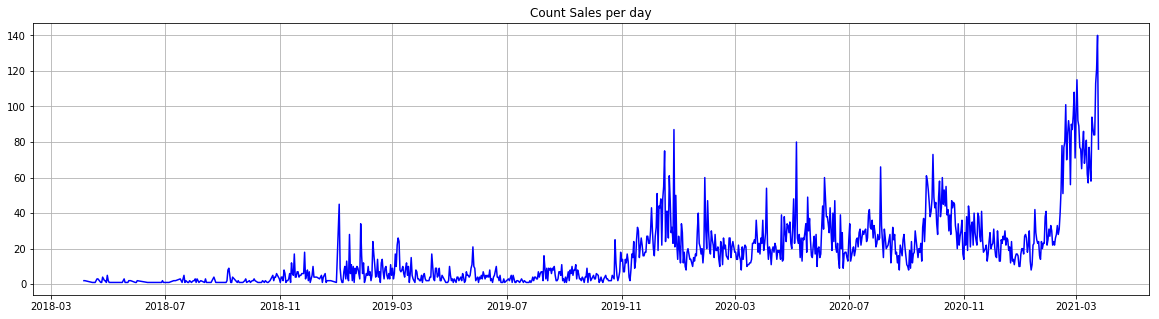

In [88]:
    plt.figure(figsize=(20,5))      
    plt.plot(stats['date'], stats['count'], c='blue')     
    plt.title('Count Sales per day')  
    plt.grid()

In [90]:
stats = sales[~sales['usd'].isnull()][['date', 'usd']].groupby('date').mean().reset_index()
stats.rename(columns={'usd': 'mean'}, inplace=True)
np.mean(stats['mean']), np.median(stats['mean'])

(726.0719816645715, 123.80137857142856)

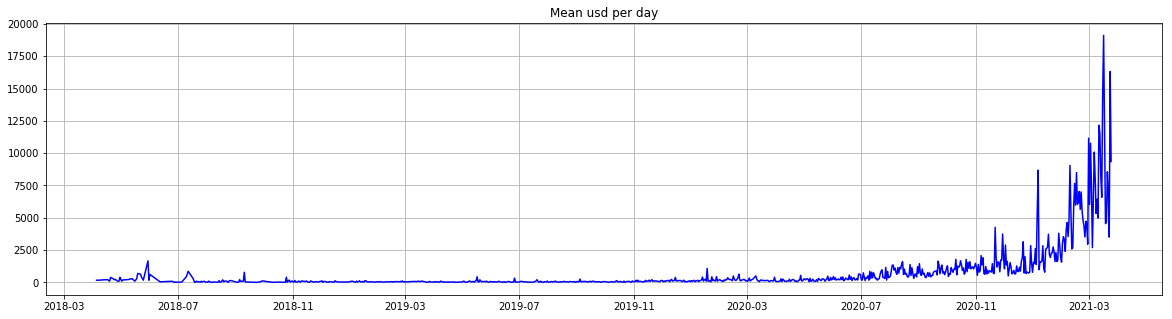

In [92]:
    plt.figure(figsize=(20,5))      
    plt.plot(stats['date'], stats['mean'], c='blue')     
    plt.title('Mean usd per day')  
    plt.grid()

In [107]:
stats = sales[(~sales['usd'].isnull())&(sales['timestamp']>=pd.to_datetime('2020-06-01'))][['date', 'usd']].groupby('date').mean().reset_index()
stats.rename(columns={'usd': 'mean'}, inplace=True)
np.mean(stats['mean']), np.median(stats['mean'])

(2081.5585812972618, 1044.9196612267801)

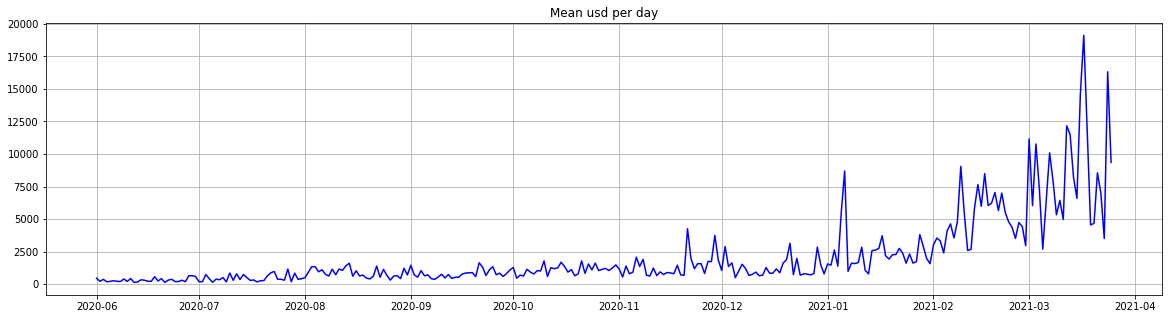

In [108]:
    plt.figure(figsize=(20,5))      
    plt.plot(stats['date'], stats['mean'], c='blue')     
    plt.title('Mean usd per day')  
    plt.grid()

In [112]:
stats = sales[(~sales['usd'].isnull())&(sales['timestamp']>=pd.to_datetime('2020-06-01'))][['date', 'usd']].groupby('date').median().reset_index()
stats.rename(columns={'usd': 'median'}, inplace=True)
np.mean(stats['median']), np.median(stats['median'])

(822.4768156723136, 483.06575)

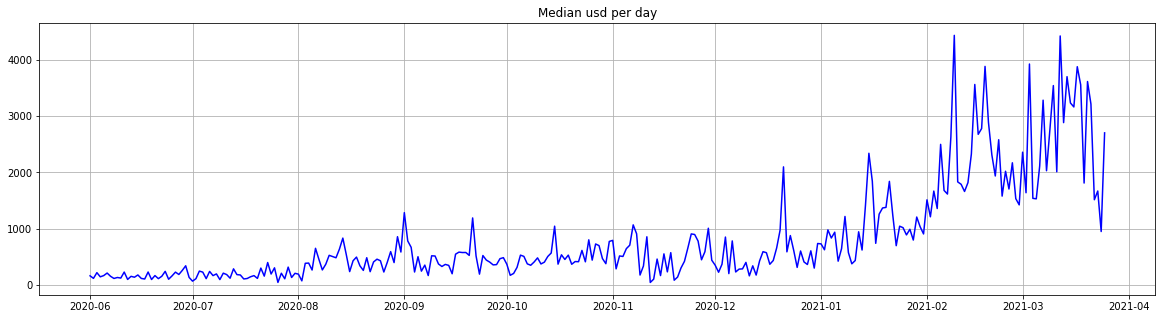

In [114]:
    plt.figure(figsize=(20,5))      
    plt.plot(stats['date'], stats['median'], c='blue')     
    plt.title('Median usd per day')  
    plt.grid()

In [115]:
stats = sales[(~sales['usd'].isnull())&(sales['timestamp']>=pd.to_datetime('2020-06-01'))][['date', 'usd']].groupby('date').max().reset_index()
stats.rename(columns={'usd': 'max'}, inplace=True)
np.mean(stats['max']), np.median(stats['max'])

(30821.674665200255, 6289.262999999999)

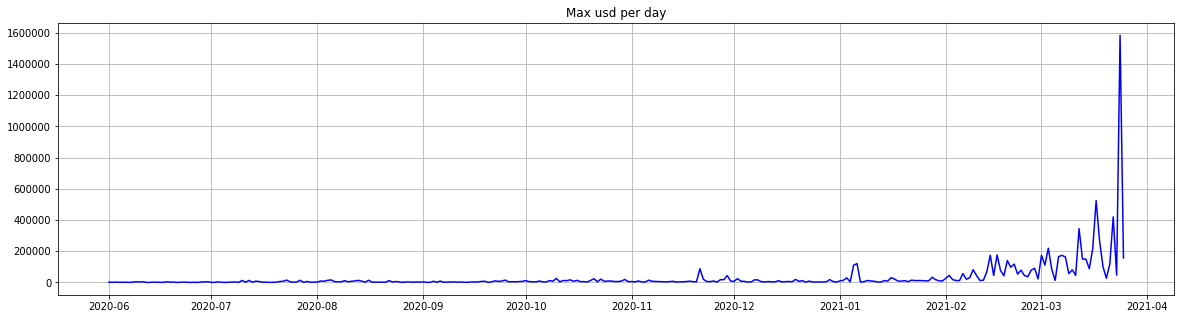

In [116]:
    plt.figure(figsize=(20,5))      
    plt.plot(stats['date'], stats['max'], c='blue')     
    plt.title('Max usd per day')  
    plt.grid()

In [109]:
stats = sales[(~sales['usd'].isnull())&(sales['timestamp']>=pd.to_datetime('2020-06-01'))][['date', 'usd']].groupby('date').sum().reset_index()
stats.rename(columns={'usd': 'sum'},inplace=True)
np.mean(stats['sum']), np.median(stats['sum'])

(113615.82441830364, 28838.919240684256)

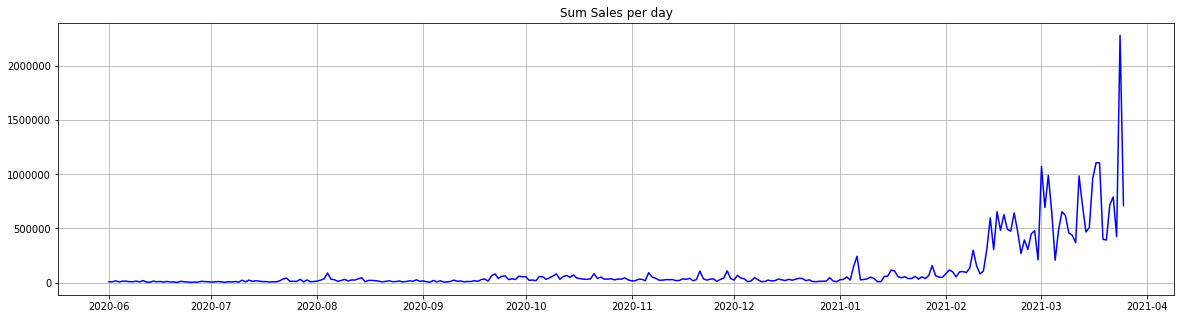

In [110]:
    plt.figure(figsize=(20,5))      
    plt.plot(stats['date'], stats['sum'], c='blue')     
    plt.title('Sum Sales per day')  
    plt.grid()

### Sum of sales per tag category in time, although items with several tags counted more than once and overall sum is not correct.

In [182]:
sales_tags = pd.merge(sales[['tokenId','timestamp','date','usd']], tags[['tokenId']+list(tag_name.keys())], on='tokenId', how='left')
sales_tags[list(tag_name.keys())] = sales_tags[list(tag_name.keys())].multiply(sales_tags['usd'], axis='index')

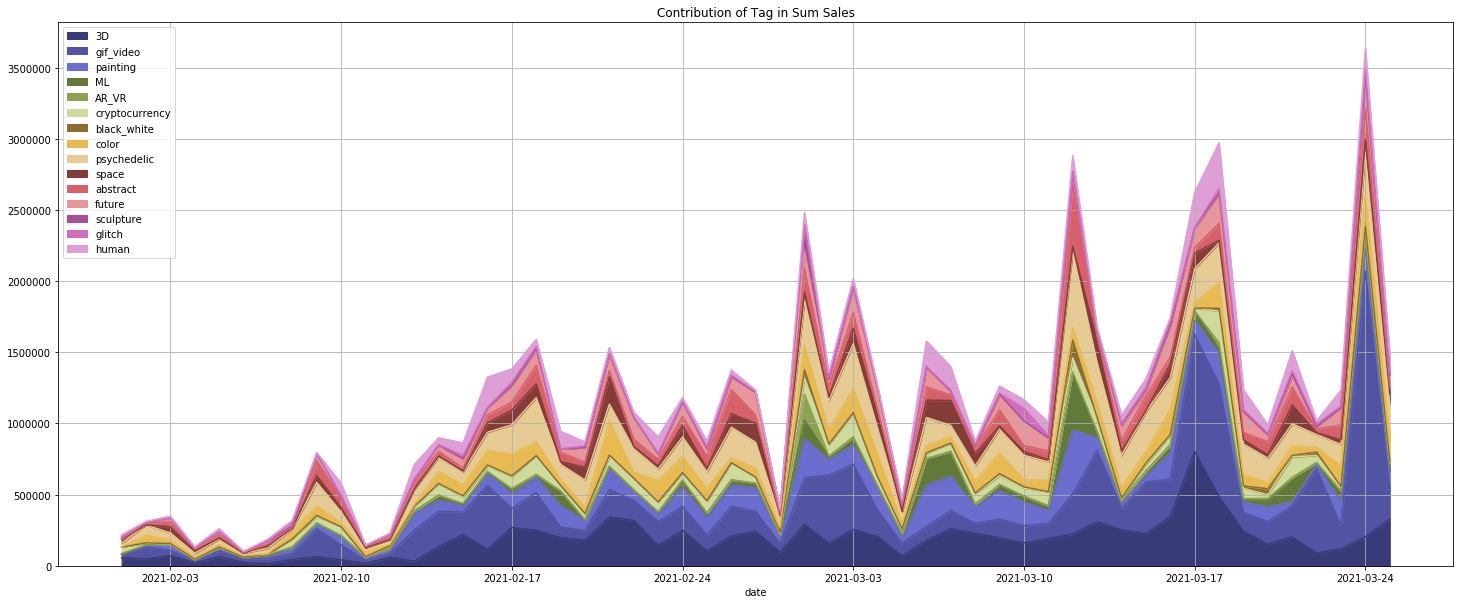

In [212]:
stats = sales_tags[(~sales_tags['usd'].isnull())&(sales_tags['timestamp']>=pd.to_datetime('2021-02-01'))][['date']+list(tag_name.keys())
                                                                                                         ].groupby('date').sum().reset_index()
stats.rename(columns={'usd': 'sum'}, inplace=True)

stats.plot.area(stacked=True, figsize=(25,10), x='date', colormap='tab20b', title='Contribution of Tag in Sum Sales', grid=True)

# Collaborative filtering. Here I make use of bids and sales to build a model which predicts most relevant items for each user based on his and other users previous bids/sales by means of revealing item's and user's embeddings, i.e. vectors expressing latent themes. 

In [10]:
interactions = pd.concat([sales[['tokenId','buyer']].drop_duplicates().rename(columns={'buyer':'userid'}),
                          bids[['tokenId', 'bidder']].drop_duplicates().rename(columns={'bidder':'userid'})])
interactions = interactions.drop_duplicates()

In [11]:
stats = interactions.groupby('userid').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count'])

(8.962722513089005, 2.0)

In [12]:
stats

,userid,count
2882,0x99d46eb671bfb7f367ebf9d5fc76b99587277de5,1906
4306,0xe703f231ab056ecb99c92a1232cc1020acfc72f8,1248
1735,0x5da7351a4cb03c33e11f51841bc614d985812821,859
3941,0xd2af803ad747ea12acf5ae468056703ae48785b5,763
4579,0xf52393e120f918ffba50410b90a29b1f8250c879,720
...,...,...
2194,0x75768def970507360802957d3f65db182f989fdd,1
2197,0x75aadf2d0ff7eb21e98eabc35ffec3602e207988,1
2198,0x75c526847d5fb1ec5a20ede7f217bf9478891c25,1
2199,0x75d077ca9c587d31063a8f97dd0b72aa624f9adf,1


In [13]:
interactions.shape

(42797, 2)

In [14]:
interactions = interactions[interactions['userid'].isin(list(stats[stats['count']>=2]['userid'].values))]
interactions.shape

(40667, 2)

In [15]:
stats = interactions.groupby('tokenId').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)
np.mean(stats['count']), np.median(stats['count'])

(2.4050505647879827, 2.0)

In [16]:
stats

,tokenId,count
42,47,24
10877,13670,22
198,365,20
11069,13907,20
6238,7899,16
...,...,...
10514,13184,1
10512,13182,1
10511,13181,1
2760,3607,1


In [17]:
stats[stats['count']>=8].shape[0], stats[stats['count']>=5].shape[0], stats[stats['count']>=4].shape[0], stats[stats['count']>=3].shape[0], stats[stats['count']>=2].shape[0]

(229, 1728, 3328, 6155, 10742)

In [19]:
rare_product_count = 2
rare_products = list(stats[stats['count']<rare_product_count]['tokenId'].values)
interactions = interactions[~interactions['tokenId'].isin(rare_products)]
interactions.shape

(34500, 2)

### Before applying the Implicit Alternating Least Squares algorithm, the data in the interaction matrix need to be weighted. The best weighting scheme for it is BM25.

In [20]:
k1 = 1.5  
b = 0.75  

def bm25_weighting(data_train):
    nonzero_sku = np.sum(data_train>0, axis=0)

    idf = {}
    for sku in list(nonzero_sku.index):
        idf[sku] = log((data_train.shape[0]-nonzero_sku[sku]+0.5)/(nonzero_sku[sku]+0.5))
    
    d = np.sum(data_train, axis=1)    
    avgdl = np.mean(d)
    tf = data_train.div(d, axis=0)

    data_train = tf.multiply(pd.Series(idf), axis=1)*(k1+1)/tf.add(k1*(1-b+b*(d/avgdl)), axis=0)
    return(data_train)

### Also some data needs to be put aside as a validation dataset to assess model quality on it.

In [21]:
interactions['flag'] = 1
data_full = pd.crosstab(interactions['userid'], interactions['tokenId'], interactions['flag'], aggfunc='sum')

random.seed(1)
test_ratio = 0.3
test_indx = random.sample(list(interactions.index), round(len(interactions.index)*test_ratio))
interactions.loc[test_indx,'flag'] = 0
data_train = pd.crosstab(interactions[interactions['flag']==1]['userid'], interactions[interactions['flag']==1]['tokenId'],
                         interactions[interactions['flag']==1]['flag'], aggfunc='sum')

data_test_flag = copy.deepcopy(data_full)
data_test_flag[data_train>0] = -1

data_full = bm25_weighting(data_full)
data_full = data_full.fillna(0)
data_train = bm25_weighting(data_train)
data_train = data_train.fillna(0)

In [636]:
used_tokenIds = list(data_full.columns)
used_users = list(data_full.index)

In [637]:
data_train = data_train.values.T
data_full = data_full.values.T
data_test_flag = data_test_flag.values.T

### Our matrix is very sparse - only about 0.1% of cells are filled.

In [638]:
np.mean(data_full>0), np.mean(data_train>0), np.mean(data_full[data_train==0]>0)

(0.001224901762878617, 0.0007798541223660529, 0.0004453949836266266)

In [639]:
data_train = sp.csr_matrix(data_train)

### Here is model training with beforehand tuned parameters. As a metric I used precision at top 30 recommended items and measured it on all data and on validation data separately. 

In [660]:
    dim_embeddings = 30
    top_k = 30

    reg = 0.002
    iters = 5

    model = implicit.als.AlternatingLeastSquares(factors=dim_embeddings, regularization=reg, iterations=iters)
    model.fit(data_train)
    
    item_embeddings = model._item_factor(list(range(data_train.get_shape()[0])), [], recalculate_item=False)
    user_embeddings = model._user_factor(list(range(data_train.get_shape()[1])), []) 
    
    preds = np.matmul(item_embeddings, user_embeddings.T)
    
    preds_new = copy.deepcopy(preds)
    preds_new[data_test_flag==-1] = np.min(preds)-1
    
    top_k_accuracy = []
    top_k_accuracy_new = []

    for user in tqdm(range(preds.shape[1])):
        k = np.min([top_k, np.sum(data_full[:,user]>0)])
        if k>0:
            top_k_accuracy += [np.sum(data_full[list(np.argsort(-preds[:,user])[:k]),user]>0)/k]       
        k = np.min([top_k,np.sum(data_test_flag[:,user]>0)])
        if k>0:
            top_k_accuracy_new += [np.sum(data_full[list(np.argsort(-preds_new[:,user])[:k]),user]>0)/k]
    
    print(np.nanmean(top_k_accuracy), np.nanmean(top_k_accuracy_new))    
    
    # 0.10849088863865676 0.0014073107345575764

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2622/2622 [00:06<00:00, 377.57it/s]

0.10849088863865676 0.0014073107345575764


### So, on validation dataset top-30 precision 0.14% versus 0.04% by random choice. Values are generally small because of data sparsity - buying a piece of art is a rare event compared to rating a movie or buying other goods.

In [648]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [661]:
np.save('item_embeddings.npy', item_embeddings)
np.save('user_embeddings.npy', user_embeddings)

save_obj(used_tokenIds, 'used_tokenIds')
save_obj(used_users, 'used_users')

save_obj(model, 'model_implicit')

In [669]:
#model = load_obj('model_implicit')
#used_tokenIds = load_obj('used_tokenIds')
#used_users = load_obj('used_users')

#item_embeddings = np.load('item_embeddings.npy')
#user_embeddings = np.load('user_embeddings.npy')

#preds = np.matmul(item_embeddings, user_embeddings.T)
#preds_new = copy.deepcopy(preds)
#preds_new[data_test_flag==-1] = np.min(preds)-1

### Create recommendations for users ans similar items for tokens

In [688]:
user_recs_implicit = pd.DataFrame(used_users, columns=['userId'])
token_recs_implicit  = pd.DataFrame(used_tokenIds, columns=['tokenId'])

used_users = np.array(used_users)
used_tokenIds = np.array(used_tokenIds)

In [697]:
for user in range(preds.shape[1]):
    user_recs_implicit.loc[user,'top_tokens'] = str(used_tokenIds[list(np.argsort(-preds_new[:,user])[:top_k])].tolist())

In [751]:
dist = euclidean_distances(item_embeddings)
for token in range(dist.shape[0]):
    token_recs_implicit.loc[token,'top_tokens'] = str(used_tokenIds[np.argsort(dist[token,:]).tolist()[1:top_k+1]].tolist())

In [753]:
user_recs_implicit.to_csv('user_recs_implicit.csv', index=False)
token_recs_implicit.to_csv('token_recs_implicit.csv', index=False)

# Here I also create user and similar items recommendations but based on Tags and Description, and measure top-30 accuracy for them

In [506]:
tokens = pd.read_csv('tokens.csv')

tokens['timestamp'] = pd.to_datetime(tokens['timestamp'])
tokens.sort_values('timestamp', inplace=True)

stats = tokens[['tokenId']].groupby('tokenId').size().reset_index()
stats.rename(columns={0: 'count'}, inplace=True)
stats = stats.sort_values('count', ascending=False)

tokens.drop(tokens[tokens['tokenId'].isin(stats[stats['count']>=2]['tokenId'])][['tokenId']].drop_duplicates(keep='last').index, inplace=True)

In [507]:
tags = pd.read_csv('tags.csv')
token_recs_description = pd.read_csv('token_recs_description.csv')

In [508]:
top_k = 30

In [509]:
top_k_accuracy_new = []

for user in tqdm(interactions['userid'].unique().tolist()):
    top_ks = []
    old_tokens = interactions[(interactions['userid']==user)&(interactions['flag']==1)]['tokenId'].tolist()
    new_tokens = interactions[(interactions['userid']==user)&(interactions['flag']==0)]['tokenId'].tolist()
    
    for token in old_tokens:
        top_ks += [ast.literal_eval(tags[tags['tokenId']==token]['similar_tags'].values[0])]
        
    top_ks = [top for top in top_ks if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if not(x in old_tokens)]
    
    k = np.min([top_k, len(new_tokens)])
    top_ks_ordered = top_ks_ordered[:top_k]
    top_k_accuracy_new += [np.sum([x in new_tokens for x in top_ks_ordered])/k]

100%|██████████| 2622/2622 [00:36<00:00, 71.20it/s] 


In [510]:
np.nanmean(top_k_accuracy_new)

0.018238579308322633

In [516]:
top_k_accuracy_new = []

for user in tqdm(interactions['userid'].unique().tolist()):
    top_ks = []
    old_tokens = interactions[(interactions['userid']==user)&(interactions['flag']==1)]['tokenId'].tolist()
    new_tokens = interactions[(interactions['userid']==user)&(interactions['flag']==0)]['tokenId'].tolist()
    
    for token in old_tokens:
        top_ks += [ast.literal_eval(token_recs_tags_2[token_recs_tags_2['tokenId']==token]['tags_2_tokens'
                                                                                          ].values[0].replace('nan,','-1,').replace(', nan',', -1'))]
        
    top_ks = [top for top in top_ks if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if not(x in old_tokens)]
    
    k = np.min([top_k, len(new_tokens)])
    top_ks_ordered = top_ks_ordered[:top_k]
    top_k_accuracy_new += [np.sum([x in new_tokens for x in top_ks_ordered])/k]

100%|██████████| 2622/2622 [00:36<00:00, 72.53it/s] 


In [517]:
np.nanmean(top_k_accuracy_new)

0.0028362928726337246

In [520]:
top_k_accuracy_new = []

for user in tqdm(interactions['userid'].unique().tolist()):
    top_ks = []
    old_tokens = interactions[(interactions['userid']==user)&(interactions['flag']==1)]['tokenId'].tolist()
    new_tokens = interactions[(interactions['userid']==user)&(interactions['flag']==0)]['tokenId'].tolist()
    
    for token in old_tokens:
        try:
            top_ks += [ast.literal_eval(token_recs_description[token_recs_description['tokenId']==token]['top_tokens'
                                                                                                    ].values[0].replace('nan,','-1,').replace(', nan',', -1'))]
        except:
            None
            
    top_ks = [top for top in top_ks if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if not(x in old_tokens+[-1])]
    
    k = np.min([top_k, len(new_tokens)])
    top_ks_ordered = top_ks_ordered[:top_k]
    top_k_accuracy_new += [np.sum([x in new_tokens for x in top_ks_ordered])/k]

100%|██████████| 2622/2622 [00:35<00:00, 74.62it/s] 


In [521]:
np.nanmean(top_k_accuracy_new)

0.001979219119864852

### Both Tags (1.8%), Tags embeddings (0.28%) and Description embeddings (0.19%) based recommendations shows higher top-30 accuracy than collaborative filtering (0.14%)

In [522]:
user_recs_tags = interactions[['userid']].drop_duplicates()
user_recs_tags.index = range(user_recs_tags.shape[0])

In [ ]:
interactions = pd.concat([sales[['tokenId','buyer']].drop_duplicates().rename(columns={'buyer':'userid'}),
                          bids[['tokenId', 'bidder']].drop_duplicates().rename(columns={'bidder':'userid'})])
interactions = interactions.drop_duplicates()

In [523]:
for i, user in tqdm(enumerate(user_recs_tags['userid'].tolist())):
    top_ks = []
    old_tokens = interactions[(interactions['userid']==user)]['tokenId'].tolist()
    
    for token in old_tokens:
        top_ks += [ast.literal_eval(tags[tags['tokenId']==token]['similar_tags'].values[0])]
        
    top_ks = [top for top in top_ks if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if not(x in old_tokens)]
    
    user_recs_tags.loc[i, 'top_tokens']  = str(top_ks_ordered[:top_k])


2622it [00:39, 66.49it/s] 


In [535]:
token_recs_description

,tokenId,top_tokens
0,1,"[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,..."
1,2,"[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,..."
2,3,"[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,..."
3,4,"[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,..."
4,5,"[934, 1715, 1417, 16, 15, 14, 13, 12, 933, 11,..."
...,...,...
22223,22209,"[22229, 22233, 22228, 22235, 1128, 20520, 2222..."
22224,22210,"[22230, 22232, 22229, 22225, 22234, 22227, 222..."
22225,22211,"[22232, 22235, 16934, 22225, 7712, 22230, 1756..."
22226,22223,"[22191, 914, 546, 14605, 2110, 16017, 9820, 19..."


In [524]:
user_recs_tags.to_csv('user_recs_tags.csv',index=False)

In [525]:
user_recs_tags_2 = interactions[['userid']].drop_duplicates()
user_recs_tags_2.index = range(user_recs_tags_2.shape[0])

In [526]:
for i, user in tqdm(enumerate(user_recs_tags_2['userid'].tolist())):
    top_ks = []
    old_tokens = interactions[(interactions['userid']==user)]['tokenId'].tolist()
    
    for token in old_tokens:
        try:
            top_ks += [ast.literal_eval(token_recs_tags_2[token_recs_tags_2['tokenId']==token]['tags_2_tokens'
                                                                                          ].values[0].replace('nan,','-1,').replace(', nan',', -1'))]
        except:
            None            
        
    top_ks = [top for top in top_ks if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if not(x in old_tokens)]
    
    user_recs_tags_2.loc[i, 'top_tokens']  = str(top_ks_ordered[:top_k])

2622it [00:37, 70.64it/s] 


In [527]:
user_recs_tags_2.to_csv('user_recs_tags_2.csv',index=False)

In [528]:
user_recs_description = interactions[['userid']].drop_duplicates()
user_recs_description.index = range(user_recs_description.shape[0])

In [529]:
for i, user in tqdm(enumerate(user_recs_description['userid'].tolist())):
    top_ks = []
    old_tokens = interactions[(interactions['userid']==user)]['tokenId'].tolist()
    
    for token in old_tokens:
        try:
            top_ks += [ast.literal_eval(token_recs_description[token_recs_description['tokenId']==token]['top_tokens'
                                                                                                    ].values[0].replace('nan,','-1,').replace(', nan',', -1'))]
        except:
            None            
        
    top_ks = [top for top in top_ks if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if not(x in old_tokens+[-1])]
    
    user_recs_description.loc[i, 'top_tokens'] = str(top_ks_ordered[:top_k])


2622it [00:37, 70.74it/s] 


In [530]:
user_recs_description.to_csv('user_recs_description.csv', index=False)

# Get predictions from each source together

In [472]:
token_recs_tags = pd.read_csv('token_recs_tags.csv')
token_recs_tags_2 = pd.read_csv('token_recs_tags_2.csv')
token_recs_description = pd.read_csv('token_recs_description.csv')
token_recs_implicit = pd.read_csv('token_recs_implicit.csv')

token_recs_tags.columns = ['tokenId', 'tags_tokens']
token_recs_tags_2.columns = ['tokenId', 'tags_2_tokens']
token_recs_description.columns = ['tokenId', 'description_tokens']
token_recs_implicit.columns = ['tokenId', 'collaborative_tokens']

In [473]:
token_recs = pd.concat([token_recs_tags[['tokenId']], token_recs_tags_2[['tokenId']], token_recs_description[['tokenId']], token_recs_implicit[['tokenId']]]).drop_duplicates()

token_recs = pd.merge(token_recs, token_recs_tags, on='tokenId', how='left')
token_recs = pd.merge(token_recs, token_recs_tags_2, on='tokenId', how='left')
token_recs = pd.merge(token_recs, token_recs_description, on='tokenId', how='left')
token_recs = pd.merge(token_recs, token_recs_implicit, on='tokenId', how='left')

### Similar item recommendation coverage. For about half of tokens collaborative recommendation are not available, for 16% not available Tags recommendations, Description based recommendations available almost for every token

In [474]:
(np.mean((token_recs['tags_tokens'].isnull())|(token_recs['tags_tokens']=='[]')), 
 np.mean((token_recs['tags_2_tokens'].isnull())|(token_recs['tags_2_tokens']=='[]')), 
 np.mean((token_recs['description_tokens'].isnull())|(token_recs['description_tokens']=='[]')), 
 np.mean((token_recs['collaborative_tokens'].isnull())|(token_recs['collaborative_tokens']=='[]')))

(0.1678438076386702,
 4.498627918484862e-05,
 4.498627918484862e-05,
 0.5167573889963561)

In [475]:
token_recs = token_recs.where(~token_recs.isnull(), other='[]')

In [476]:
intersection_t2 = []
intersection_td = []
intersection_tc = []
intersection_2d = []
intersection_2c = []
intersection_dc = []

for i in token_recs.index:
    (tags_tokens, tags_2_tokens, description_tokens, collaborative_tokens) = token_recs.loc[i][['tags_tokens', 'tags_2_tokens',
                                                                                                'description_tokens', 'collaborative_tokens']]
    
    tags_tokens = ast.literal_eval(tags_tokens)
    tags_2_tokens = ast.literal_eval(tags_2_tokens.replace('nan,','-1,').replace(', nan',', -1'))
    description_tokens = ast.literal_eval(description_tokens.replace('nan,','-1,').replace(', nan',', -1'))
    collaborative_tokens = ast.literal_eval(collaborative_tokens)

    intersection_t2 += [len(set(tags_tokens)&set(tags_2_tokens))/60]
    intersection_td += [len(set(tags_tokens)&set(description_tokens))/60]
    intersection_tc += [len(set(tags_tokens)&set(collaborative_tokens))/60]
    intersection_2d += [len(set(tags_2_tokens)&set(description_tokens))/60]
    intersection_2c += [len(set(tags_2_tokens)&set(collaborative_tokens))/60]
    intersection_dc += [len(set(description_tokens)&set(collaborative_tokens))/60]

### Below are pairwise intersections of the top-30 list from each source. Overlap is quite low.

In [477]:
np.nanmean(intersection_t2), np.nanmean(intersection_td), np.nanmean(intersection_tc), np.nanmean(intersection_2d), np.nanmean(intersection_2c), np.nanmean(intersection_dc)

(0.00557529953364224,
 0.0008457420486751541,
 0.0005413348928576783,
 0.015566002369277371,
 0.0003733861172342436,
 0.0003838829157107082)

### Make a compilation of all three sources into one list keeping the order

In [478]:
for i in token_recs.index:
    (tags_tokens, tags_2_tokens, description_tokens, collaborative_tokens) = token_recs.loc[i][['tags_tokens', 'tags_2_tokens',
                                                                                                'description_tokens', 'collaborative_tokens']]
    
    tags_tokens = ast.literal_eval(tags_tokens)
    tags_2_tokens = ast.literal_eval(tags_2_tokens.replace('nan,','-1,').replace(', nan',', -1'))
    description_tokens = ast.literal_eval(description_tokens.replace('nan,','-1,').replace(', nan',', -1'))
    #description_tokens = [x for x in description_tokens if not(x==-1)]
    collaborative_tokens = ast.literal_eval(collaborative_tokens)
    
    top_ks = [top for top in [tags_tokens, tags_2_tokens, description_tokens, collaborative_tokens] if len(top)!=0]
    top_ks_ordered = [top[i] for i in range(top_k) for top in top_ks]
    used = set()
    top_ks_ordered = [x for x in top_ks_ordered if x not in used and (used.add(x) or True)]
    top_ks_ordered = [x for x in top_ks_ordered if x!=-1]
    
    token_recs.loc[i, 'compilation_tokens'] = str(top_ks_ordered[:top_k])    

In [479]:
token_recs.to_csv('token_recs.csv', index=False)

In [ ]:
user_recs_implicit.to_csv(filename_user_recs_implicit, index=False)

In [536]:
user_recs_implicit = pd.read_csv('user_recs_implicit.csv')

In [537]:
user_recs_implicit

,userId,top_tokens
0,0x00121a3d3470a1175afbcf9f535855f2aa03b741,"[5, 8, 17, 3, 55, 50, 1221, 1811, 2071, 15, 14..."
1,0x00362d9f53023ee0fde44773c3fa79917adb094b,"[1, 2, 41, 10, 50, 47, 1011, 14654, 20430, 201..."
2,0x0055cd5f017027d10adf4f13332181e6d8d886bb,"[5, 8, 1, 7, 47, 50, 2, 14, 10, 41, 34, 76, 28..."
3,0x00668bd79ede077b99bbe1c4db59418bc333d4cf,"[5, 8, 7, 11, 28, 12, 2, 18449, 8408, 8834, 16..."
4,0x007abdd190137f614701a6216fd703329afbcdf1,"[1, 5, 8, 7, 50, 47, 2, 14, 10, 41, 34, 42, 69..."
...,...,...
2617,0xff52319f6e041a63565413a445f2c105f66255b6,"[1, 19874, 21077, 16219, 17593, 9004, 10, 1113..."
2618,0xff6ddb157773197c31a834f6a294c7d0c0abc79f,"[8, 645, 2, 20808, 20986, 16811, 19905, 19523,..."
2619,0xff7197d0aaec7ae574d83788782698f793f6ff01,"[1, 5, 20405, 11737, 20884, 21142, 17801, 1952..."
2620,0xff9047df0bb314205a3c686226df0e474873acec,"[5, 1, 10, 17964, 785, 11737, 7302, 710, 17456..."


In [480]:
token_recs

,tokenId,tags_tokens,tags_2_tokens,description_tokens,collaborative_tokens,compilation_tokens
0,1,"[2, 3, 4, 65, 66, 1286, 15773, 11838, 20866, 2...","[2, 3, 4, 62, 63, 84, 85, 81, 95, 20452, 83, 8...","[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,...","[2, 10, 34, 47, 16, 56, 1520, 5006, 1858, 1745...","[2, 3, 10, 4, 34, 65, 62, 9667, 47, 66, 63, 93..."
1,2,"[1, 3, 4, 65, 66, 1286, 15773, 11838, 20866, 2...","[2, 3, 4, 62, 63, 84, 85, 81, 95, 20452, 83, 8...","[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,...","[10, 14654, 20103, 47, 20016, 19875, 19049, 20...","[1, 2, 10, 3, 14654, 4, 20103, 65, 62, 9667, 4..."
2,3,"[1, 2, 4, 65, 66, 1286, 15773, 11838, 20866, 2...","[2, 3, 4, 62, 63, 84, 85, 81, 95, 20452, 83, 8...","[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,...","[10317, 14947, 16463, 13324, 18928, 2152, 1274...","[1, 2, 10317, 3, 14947, 4, 16463, 65, 62, 9667..."
3,4,"[1, 2, 3, 65, 66, 1286, 15773, 11838, 20866, 2...","[2, 3, 4, 62, 63, 84, 85, 81, 95, 20452, 83, 8...","[2, 3, 4, 9667, 9333, 9487, 9517, 9571, 12152,...","[14057, 3341, 13856, 8251, 10706, 10426, 1016,...","[1, 2, 14057, 3, 3341, 4, 13856, 65, 62, 9667,..."
4,5,"[979, 1020, 1058, 1510, 1600, 2020, 2058, 2176...","[8025, 1500, 14, 9179, 7404, 5869, 7103, 5638,...","[934, 1715, 1417, 16, 15, 14, 13, 12, 933, 11,...","[20103, 14654, 20884, 12, 20016, 16219, 11, 18...","[979, 8025, 934, 20103, 1020, 1500, 1715, 1465..."
...,...,...,...,...,...,...
22224,22209,"[50, 51, 52, 71, 74, 72, 73, 112, 151, 566, 58...","[22229, 1291, 17598, 1137, 14391, 6252, 3059, ...","[22229, 22233, 22228, 22235, 1128, 20520, 2222...",[],"[50, 22229, 51, 1291, 22233, 52, 17598, 22228,..."
22225,22210,[],"[22230, 22227, 22225, 22229, 22226, 6397, 2223...","[22230, 22232, 22229, 22225, 22234, 22227, 222...",[],"[22230, 22227, 22232, 22225, 22229, 22226, 222..."
22226,22211,[],"[22232, 22227, 4632, 6397, 21917, 6597, 15161,...","[22232, 22235, 16934, 22225, 7712, 22230, 1756...",[],"[22232, 22227, 22235, 4632, 16934, 6397, 22225..."
22227,22223,"[1048, 1386, 1442, 1443, 1448, 1464, 1528, 165...","[5634, 3143, 5649, 21919, 21119, 21805, 8478, ...","[22191, 914, 546, 14605, 2110, 16017, 9820, 19...",[],"[1048, 5634, 22191, 1386, 3143, 914, 1442, 564..."
